# Binær klassifisering ved hjelp av et nevralt nettverk

## Introduksjon

I denne oppgaven skal det utføres en binær klassifisering av ulike typer bilder. Modellen som skal brukes er et nevralt nettverk med en forholdsvis beskjeden dybde. 
$\color{red}{Mer \, spesifikt \, om \, hvordan \, modellen \, er \, bygget \, opp?}$

Tilnærmingen til problemet er todelt: 
* En treningsfase der parametrene assosiert med hver transformasjon som gir lavest mulig avvik finnes. Avviket beregnes ved hjelp av en kostfunksjon,som benytter seg av et sett med labels. Dette er essensielt en liste over de ulike punktenes reelle binære klassifisering, slik at modellen sin klassifisering kan sammenlignes med denne. 
* En valideringsfase der bilder som ikke ble brukt i treningsfasen transformeres med parameterne som ble funnet. Herfra kan man trekke en konklusjon om modellen klassifiserer bildene på en god måte eller ikke. 

I testproblem 1 skal punkter i planet klassifiseres. Det skal skilles mellom to typer punkter. Her er de valgt til å være henholdsvis røde og blå. "Bildet" i dette problemet er et punkt, kun beskrevet av to koordinater $(x,y)$. Modellen skal dermed trenes til å avgjøre om et vilkårlig punkt er rødt eller blått.

I testproblem 2 skal siffer fra MNIST klassifiseres. Her er det snakk om virkelige bilder med lav oppløsning. Størrelsen på bildene er 28 x 28 piksler. Bildene i settene fra MNIST består av siffer fra 0-9, dvs 10 ulike klasser av bilder. For at dette skal passe inn i vår binære klassifiseringsmodell holder vi oss til kun to forskjellige siffer, som for eksempel 4 og 9. 


## Testproblem 1 - punkter i planet


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math #IMPORTERTE MATH FORDI JEG FIKK EN FEILKODE OM AT DEN IKKE FINNES!
from spirals import*

def sigma(x):
    return np.tanh(x)

def sigma_der(x):
    return np.cosh(x)**(-2)

def eta(x):
    return 0.5*(1+np.tanh(x/2))

def eta_der(x):
    return np.e**(x)*(np.e**(x)+1)**(-2)

def adam_method(x, x_der, m_jn, v_jn, j):
    beta_1 = 0.9
    beta_2 = 0.999
    alfa = 0.01
    epsilon = 1e-8
    m_j = beta_1*m_jn + (1-beta_1)*x_der
    v_j = beta_2*v_jn + (1-beta_2)* (x_der*x_der)
    m_hatt_j = m_j/(1-beta_1**(j))
    v_hatt_j = v_j/(1-beta_2**(j))
    val = alfa*m_hatt_j/(np.sqrt(v_hatt_j) + epsilon)
    x -= val
    return x, m_j, v_j

def set_random_parameters(K, d):
    ''' W_k er en dxd matrise og  (2x2 for leketøysmodellen)
        b_k er en dx1 vektor elementer for hver k  (2x1 for leketøysmodellen)
    ''' 
    W_k = np.random.randn(K,d,d)
    b_k = np.random.randn(K,d,1)  
    omega = np.random.randn(d)     
    my = np.random.rand() 
    return W_k, b_k, omega, my

def initialize(K,d,I):
    Y_Kk = np.zeros((K+1,d,I))
    b_k_dim = np.zeros((K,d,I))
    J_der_W = np.zeros((K,d,d))
    J_der_b = np.zeros((K,d,1))
    vec_I = np.ones((I,1))  #Må gjøre vec_I til en matrise av en eller annen grunn
    P_Kk = np.zeros((K,d,I)) #K matriser, skal ikke ha med P_0
    return Y_Kk, b_k_dim, J_der_W, J_der_b, vec_I, P_Kk

def testing(my, omega, b_k, W_k, Y_Kk, b_k_dim, h, K):
    for i in range(K):
        b_k_dim[i,:,:] = b_k[i,:,:]   
        Y_Kk[i+1,:,:] = Y_Kk[i,:,:] + h*sigma(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])
        
    Z = eta(np.transpose(Y_Kk[-1,:,:]) @ omega + my)  #Ix1 vektor 
    return Y_Kk, b_k_dim, Z

def calculate_projection_derivatives(my, omega, Y_Kk, Z, c):
    ''' Calculates parts of gradient (5) and (6) '''
    YT_k = np.transpose(Y_Kk[-1,:,:])
    J_der_my = eta_der(YT_k @ omega + my) @ (Z-c)    #Blir en skalar  
    J_der_omega = Y_Kk[-1,:,:] @ ((Z-c) * eta_der(YT_k @ omega + my)) #Blir en dx1 vektor
    return J_der_my, J_der_omega

def calculate_rest_of_gradient(my, omega, b_k_dim, W_k, Y_Kk, Z, c, h, K, P_Kk, J_der_W, J_der_b, vec_I):
    ''' Calculates P_(k-1) from (8) '''
    YT_k = np.transpose(Y_Kk[-1,:,:])
    P_k = np.outer(omega,(Z-c)*eta_der(YT_k @ omega + my))
    P_Kk[-1,:,:] = P_k      #Legger P_k bakerst i P_Kk

    for i in range(K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
        P_Kk[i-1,:,:] = P_Kk[i,:,:] + h*np.transpose(W_k[i-1,:,:]) @ (sigma_der(W_k[i-1,:,:] @ Y_Kk[i-1,:,:] +b_k_dim[i-1,:,:]) * P_Kk[i,:,:])
    
    for i in range(K):
        val = P_Kk[i,:,:] * sigma_der(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])
        J_der_W[i,:,:] = h*(val @ np.transpose(Y_Kk[i,:,:]))
        J_der_b[i,:,:] = h*(val @ vec_I)
        
    return J_der_W, J_der_b

def stochastic_gradient_descent(Y_0, C, I_tot, chunk): #Denne må implementeres i algoritmen, men jeg skjønner ikke helt hvordan? :(
    ''' Made to pick out pictures to test. Modifies the Adam Descent Algorithm. ''' 
    start = np.random.randint(I_tot-chunk)
    Y0_chunk = Y_0[:,start:start+chunk] #picks out 50 pictures! Important to use in MNIST-task.
    C_chunk = C[start:start+chunk]
    return Y0_chunk, C_chunk

def algorithm(Y_0, c, K, d, iterations, h, I, chunk):
    
    W_k, b_k, omega, my = set_random_parameters(K, d)
    
    j = 1   #Må starte på 1
    J = np.zeros(iterations)
    
    stocastic_method = False
    if chunk < I: #Stocastic method
        I_tot = I  #new variable name
        I = chunk  #to get right dimensions below
        Y_0_tot = Y_0
        c_tot = c
        stocastic_method = True
    
    Y_Kk, b_k_dim, J_der_W, J_der_b, vec_I, P_Kk = initialize(K, d, I)
    
    #Til Adam-metoden:
    v_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
    m_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
    
    while j <= iterations:
        if stocastic_method:
            Y_0, c = stochastic_gradient_descent(Y_0_tot, c_tot, I_tot, chunk)
            
        Y_Kk[0,:,:] = Y_0
        Y_Kk, b_k_dim, Z = testing(my, omega, b_k, W_k, Y_Kk, b_k_dim, h, K) #Makes new Y_Kk and b_k_dim
        
        J[j-1] = 0.5*np.linalg.norm(Z-c)**2
        
        J_der_my, J_der_omega = calculate_projection_derivatives(my, omega, Y_Kk, Z, c)
        
        J_der_W, J_der_b = calculate_rest_of_gradient(my, omega, b_k_dim, W_k, Y_Kk, Z, c, h, K, P_Kk, J_der_W, J_der_b, vec_I)
        
        my, m_j[0],v_j[0] = adam_method(my, J_der_my, m_j[0], v_j[0], j)
        omega, m_j[1],v_j[1] = adam_method(omega,J_der_omega,m_j[1],v_j[1], j)
        b_k, m_j[2],v_j[2] = adam_method(b_k,J_der_b,m_j[2],v_j[2], j)
        W_k, m_j[3],v_j[3] = adam_method(W_k,J_der_W,m_j[3],v_j[3], j) 
        j+= 1
    return Y_Kk, J, W_k, b_k, omega, my, c

In [30]:
#Forberedelser til opg. 1
I = 1000  #antall bilder, kan økes til 1000 punkter/bilder
d = 2   #x- og y-koordinat
K = 15  #antall transformajsoner, kan økes til 15-20
h = 0.1 #skrittlengde
iterations = 1000  #kan økes til 40 000
chunk = I

Y_0, c = get_data_spiral_2d(I)  
c = c[:,0]

Y_Kk, J, W_k, b_k, omega, my, c = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)

print(J[0],J[-5:])  #god overeenstemmelse

155.56255349711935 [0.00057019 0.0005699  0.0005696  0.00056931 0.00056901]


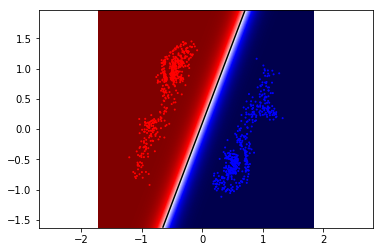

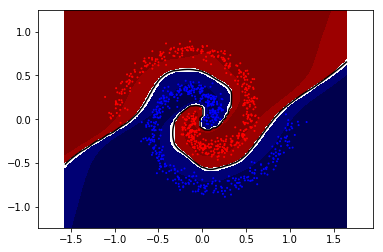

In [31]:
from plotting import*  #funker ikke å importere tydeligvis?

def forward_function(grid): #Denne må nesten transformere gridet slik som Y0, slik at vi kan se hvilke punkter av gridet som hører til hvilken arm?
    ''' A function that takes one argument, an ?2-by-S? matrix of S datapoints, and
    returns a vector of S classification values.'''
    b_k_dim = np.zeros((K,d,len(grid[0,:])))
    for i in range(K): 
        b_k_dim[i,:,:] = b_k[i,:,:]   
        grid_k = grid + h*sigma(W_k[i,:,:] @ grid + b_k_dim[i,:,:])
        grid = grid_k

    grid_Tk = np.transpose(grid_k)
    Z = eta(grid_Tk @ omega + my)
    return Z
                                        
def last_function(grid): #Siste Y
    ''' A function that takes one argument, and S-by-2 matrix of S intermediate states in
    the network, and returns a vector of S classification values.
    It should multiply by w, add μ and evaluate 𝜂. '''
    vec_I = np.ones(I) 
    Z = eta(np.transpose(grid) @ omega + my)
    return Z



#plot_progression(Y_Kk, c)
plot_separation(last_function,Y_Kk[-1,:,:],c,100) #Denne gir et fint plot derimot
#plot_separation(last_function,Y_Kk[0,:,:],c,100)
plot_model(forward_function,Y_Kk[0,:,:],c,100)

## Testproblem 2 - håndskrevne siffer

In [36]:
from loader import*

K = 10  #antall transformajsoner, kan økes til 15-20
h = 0.1 #skrittlengde
iterations = 100  #kan økes til 40 000

#Forberedelser til opg. 2
Y_0, c = get_dataset()
c = c[:,0]

d = 784   #28x28
chunk = 50

Y_Kk, J, W_k, b_k, omega, my, c = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)

print(J) #Alt blit nan utenom de første elementene i J

C:\Users\joste\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in power
  app.launch_new_instance()
C:\Users\joste\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\Users\joste\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in cosh
  # Remove the CWD from sys.path while we load stuff.
C:\Users\joste\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in cosh
  # Remove the CWD from sys.path while we load stuff.


[13. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
